#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션1
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.


### (2) 미션2
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature 가 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project3_1 폴더를 만들고, 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 라이브러리 로딩

* 라이브러리 로딩

In [513]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

* 제공 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [515]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [518]:
data = pd.read_csv('data01_train.csv')
data.drop(columns='subject', inplace=True)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [519]:
data_test = pd.read_csv('data01_test.csv')
data_test.drop(columns='subject', inplace=True)
data_test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [523]:
data.shape

(5881, 562)

In [524]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [525]:
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [526]:
print(data.isna().sum())

tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
tBodyAcc-std()-X                        0
tBodyAcc-std()-Y                        0
                                       ..
angle(tBodyGyroJerkMean,gravityMean)    0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
Activity                                0
Length: 562, dtype: int64


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [529]:
target = 'Activity'
print('='*15, '<빈도수>','='*15)
print(data[target].value_counts())
print('='*15, '<비율>','='*15)
print(data[target].value_counts(normalize=True))

=============== <빈도수> ===============
Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64
=============== <비율> ===============
Activity
LAYING                0.189594
STANDING              0.184833
SITTING               0.175480
WALKING               0.169699
WALKING_UPSTAIRS      0.145894
WALKING_DOWNSTAIRS    0.134501
Name: proportion, dtype: float64


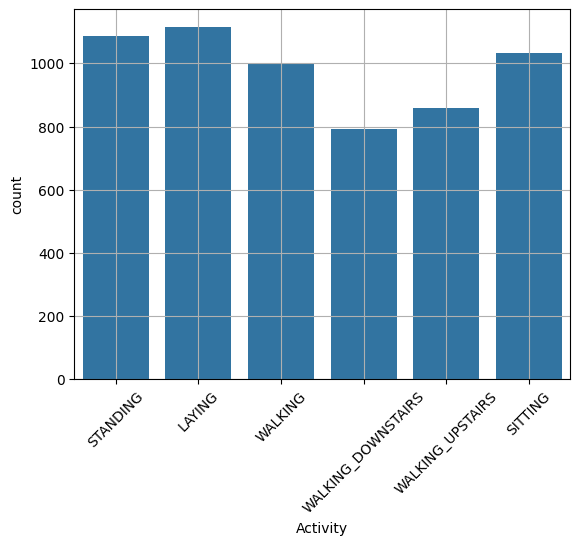

In [530]:
# 시각화 
sns.countplot(x=target, data=data)
plt.xticks(rotation=45)
plt.grid()
plt.show()

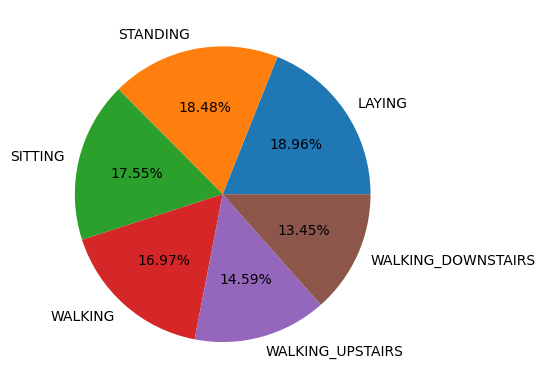

In [531]:
# 시각화 - 파이차트
temp = data[target].value_counts()

plt.pie(temp.values, labels = temp.index, autopct = '%.2f%%')
plt.show()

## 3.미션1 : 데이터 분석1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **트리 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [537]:
# 데이터 분리
x = data.drop(columns=target)
y = data.loc[:, target]

In [538]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 7:3으로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

#### 2) 모델링

In [540]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[330   0   0   0   0   1]
 [  0 277  15   0   0   0]
 [  0  15 316   0   0   0]
 [  0   0   0 293   1   3]
 [  0   0   0   2 233   4]
 [  0   0   0   0   2 273]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       331
           SITTING       0.95      0.95      0.95       292
          STANDING       0.95      0.95      0.95       331
           WALKING       0.99      0.99      0.99       297
WALKING_DOWNSTAIRS       0.99      0.97      0.98       239
  WALKING_UPSTAIRS       0.97      0.99      0.98       275

          accuracy                           0.98      1765
         macro avg       0.98      0.98      0.98      1765
      weighted avg       0.98      0.98      0.98      1765



#### 3) 변수 중요도 추출

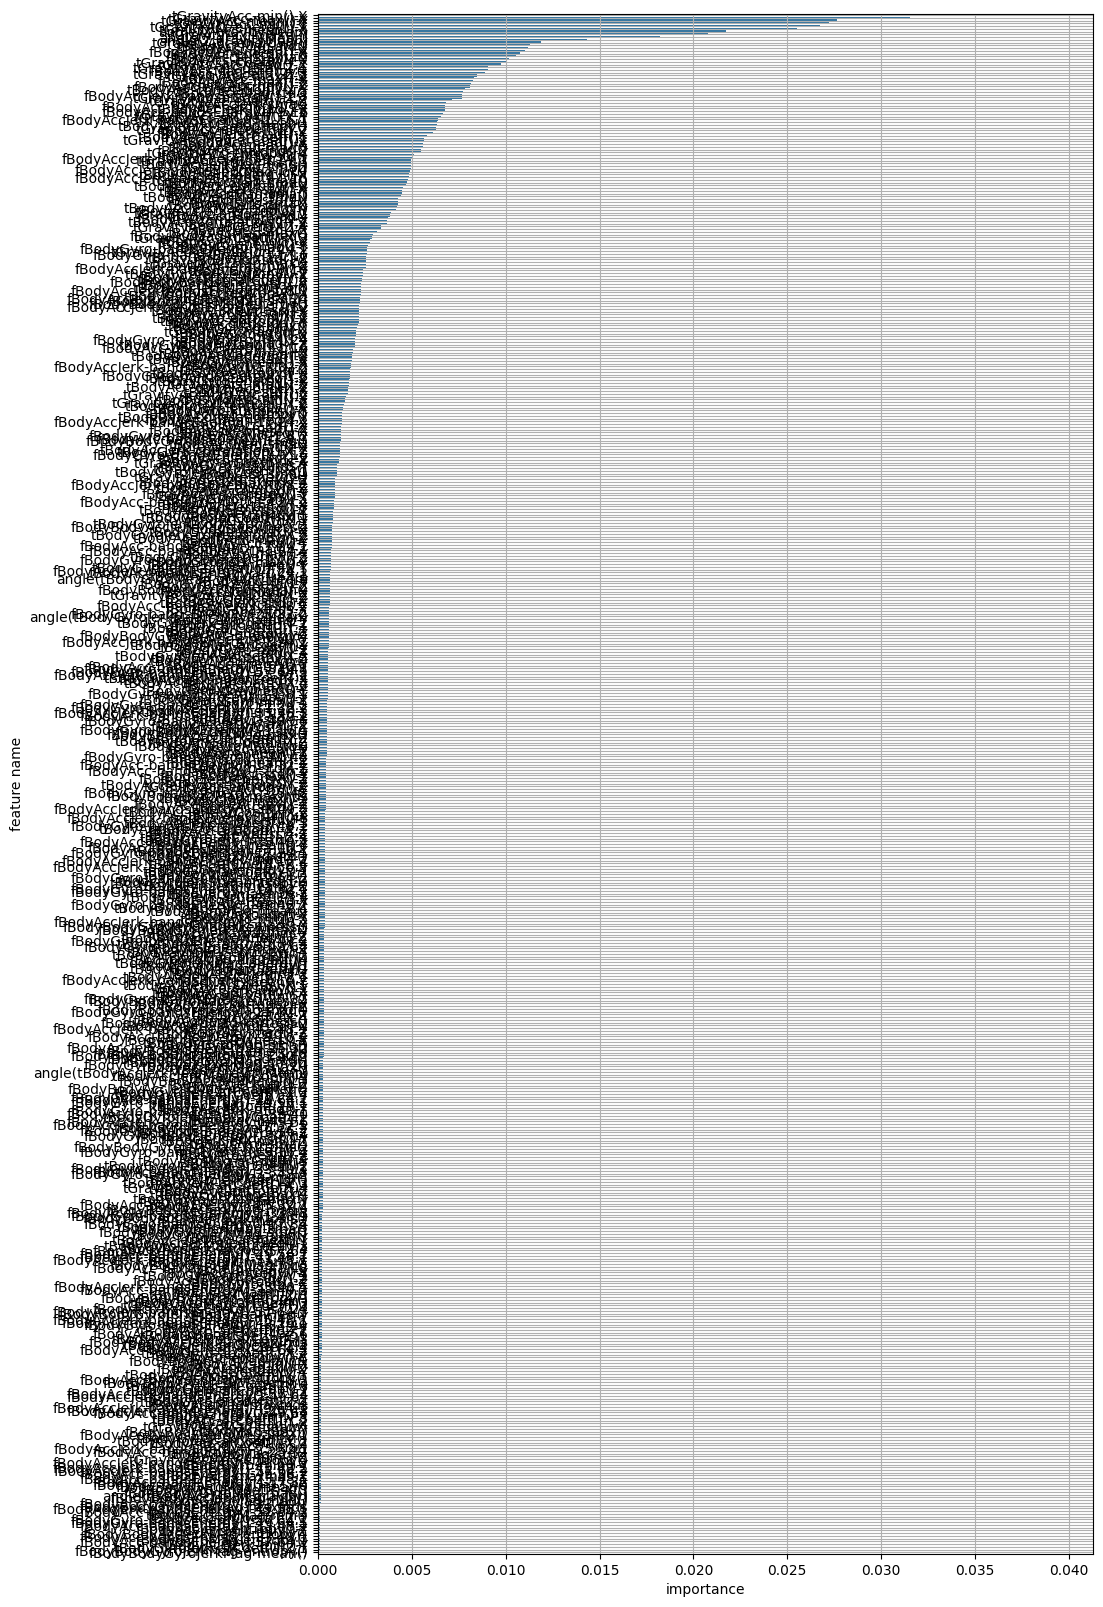

In [542]:
fi_df = plot_feature_importance(model.feature_importances_, x_train.columns, result_only = False, topn = 'all')

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [546]:
top = fi_df['feature_name'].head()
top

0       tGravityAcc-min()-X
1       tGravityAcc-max()-X
2      tGravityAcc-mean()-Y
3       tGravityAcc-min()-Y
4    tGravityAcc-energy()-X
Name: feature_name, dtype: object

In [547]:
bottom = fi_df['feature_name'].tail().reset_index(drop=True)
bottom

0    fBodyAcc-bandsEnergy()-57,64.1
1              tBodyAccJerk-min()-Y
2       tBodyGyroJerk-arCoeff()-Z,1
3    fBodyBodyGyroJerkMag-entropy()
4       fBodyBodyGyroJerkMag-mean()
Name: feature_name, dtype: object

#### 2) 상위 5개 변수에 대한 분석

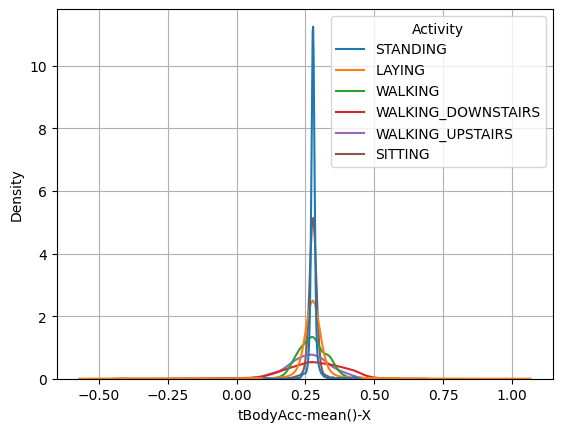

In [549]:
# tBodyAcc-mean()-X
feature = 'tBodyAcc-mean()-X'
target = 'Activity' # 미션2에서는 'is_Dynamic'
sns.kdeplot(x = feature, data = data, hue = target)
plt.grid()
plt.show()

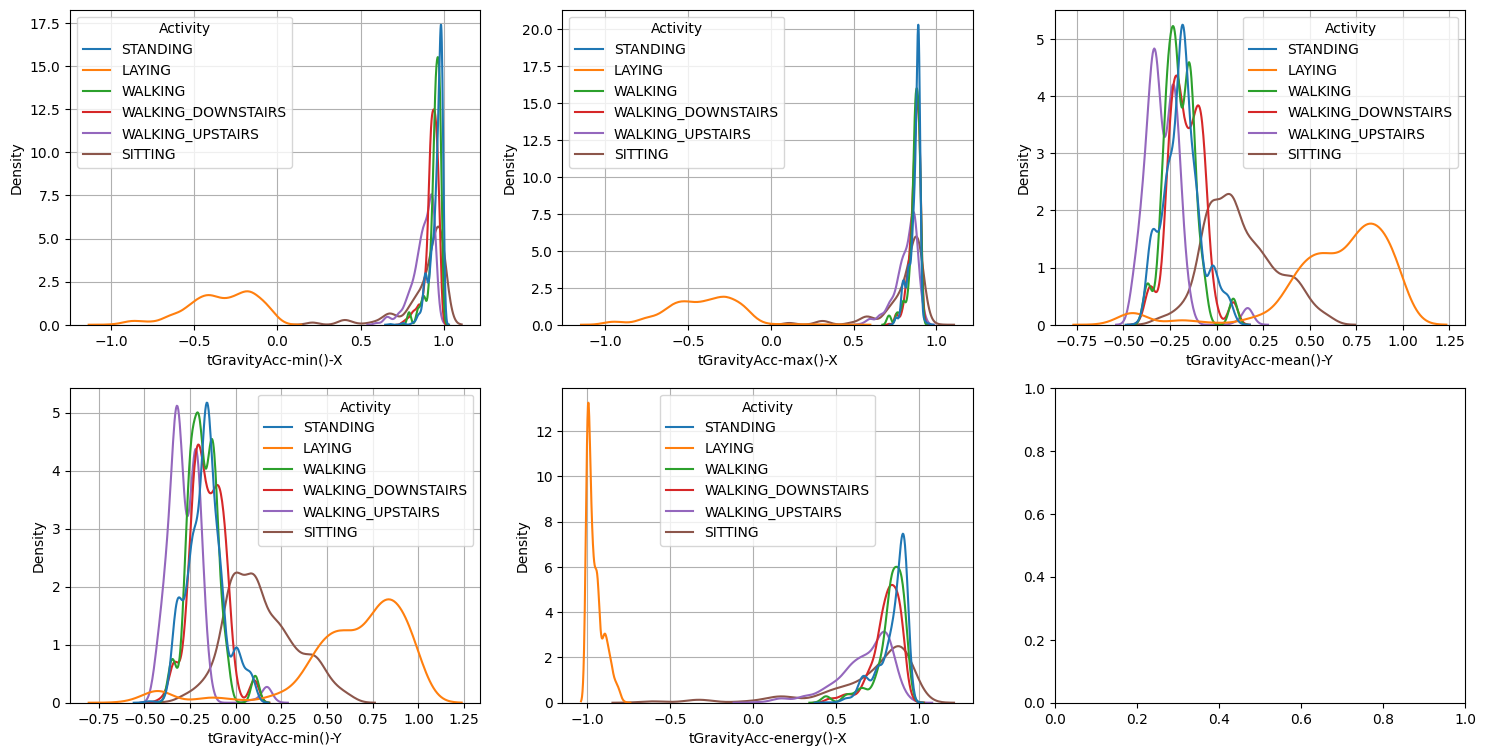

In [550]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
for i, ax in enumerate(axes.flatten()):
    if i < len(top): 
        sns.kdeplot(x=top[i], data = data, hue = target, ax=ax, common_norm=False)
        ax.grid()
plt.show()

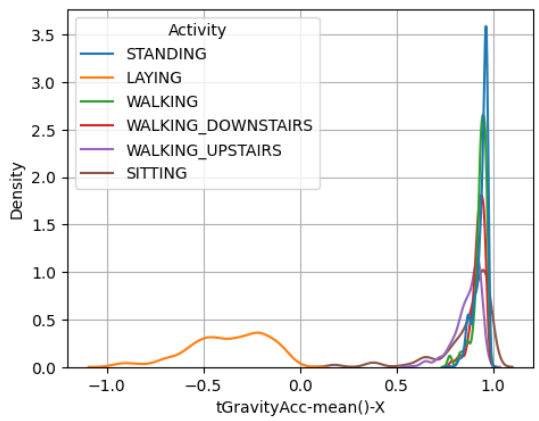

- **tGravityAcc-mean()-X: 중력 가속도의 X축 방향 평균값**
- Laying은 -1에서 0까지 완만하고 밀도가 낮은 그래프
  - 중력 가속도 X축 방향에서 거의 변동이 없음을 보임.
  - 즉, 눕는 동안 X축 방향으로 큰 움직임이 없고, 거의 정적인 상태를 유지
    

- 나머지는 약 1.0에서 뾰족한 그래프 형태로 보임.
  - 중역 가속도 X축 방향에서 거의 1에 가까운 값으로 수렴.
  - 대부분 서있거나 움직이는 활동이고, 일정한 움직임이나 자세가 유지된다는 것으로 보임.

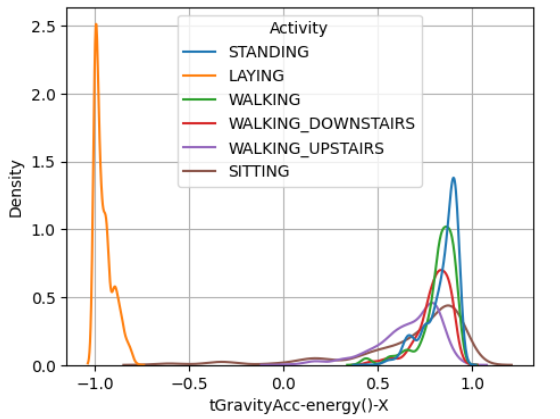

- **tGravityAcc-energy()-X: 중력 가속도 X축 방향의 에너지**
- laying이 -1에 뾰족한 그래프 형태(밀도는 2.5)이고, 나머지는 0.5 ~ 1 사이에서 조금 뾰족한 형태(밀도는 약 1.5 ~ 0.5사이에 분포, 약간 왼쪽으로 꼬리가 긴 그래프)임.
  
- Laying은 중력 가속도 X축 방향의 에너지가 매우 일정하고 거의 변화가 없어보임.
  - -1에 집중되어 있는 것은 X축 방향에서 움직임이 거의 없는 매우 정적임.
  - 즉, 에너지가 거의 소모되지 않으며, X축 방향으로 중력에 의한 에너지가 음수로 안정된 상태
  
- 나머지는 X축 방향으로 적당한 에너지가 소비되어 보임.
  - 왼쪽으로 꼬리가 긴 그래프 (Walking_upstairs..)는 비교적 적은 에너지를 소비하지만, 일부 경우에는 더 낮은 에너지 값을 가질 수 있음을 보여줌.
  - 즉, 특정 순간들에서는 에너지 소모가 적어지거나 멈추는 경우

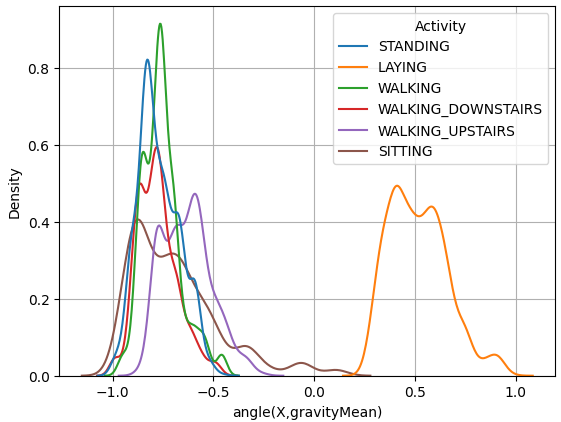

- **angle(X,gravityMean): X축 방향 가속도와 전체 중력 벡터의 평균 간의 각도**
- Laying은 0.3 ~ 1 사이에서 비교적 완만한 그래프 형태이고, 나머지는 -1 ~ -0.5 사이에서 뾰족한 그래프 형태임.

- Laying은 신체의 각도가 비교적 일관되게 유지되며, 중력 방향과 안정된 관계를 유지
  - 즉, 움직임이 적음.
 
- 나머지는 뾰족한 그래프 형태로, 일관된 범위 내에서 변동
  - 즉, 특정한 범위 내에서 일정하게 유지.
  - 오른쪽으로 꼬리가 길고 비교적 밀도가 0.4로 낮은 Sitting은 일부 상황에서는 각도의 변화가 있을 수 있음. (자세변화, 움직임의 변동 등)

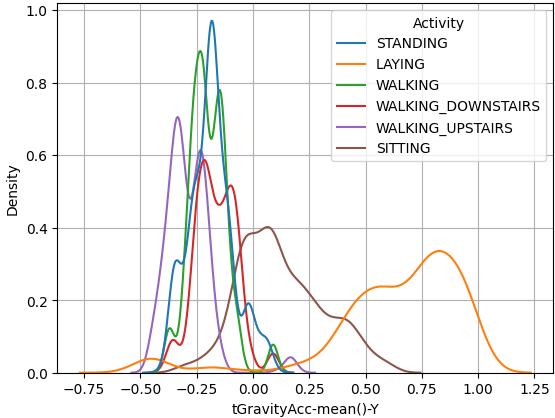

- **tGravityAcc-mean()-Y: 중력 가속도의 Y축 방향에서의 평균**
- laying은 0.5 ~ 1 사이에 대부분 분포하며, 밀도는 약 0.3까지 올라가는 완만한 형태의 그래프임.
  - Y축으로 중력 가속도가 크게 작용하지 않으며, 비교적 양의 방향에 집중되어 있음. 즉, Y축으로 중력의 영향이 크지 않고, 대체로 안정적인 상태
  - 왼쪽으로 꼬리가 긴 형태로, 가끔 Y축 가속도가 더 낮은 값으로 감. 미세한 움직임이나 자세 변화로 변동하는 듯.

- sitting은 -0.1 ~ 0.25 사이에 대부분 분포하며, 밀도는 약 0.4까지 올라가는 비교적 완만한 형태의 그래프임.
  - 0 근처에서 안정된 상태로 유지되어 보임. 앉는 동안 자세가 비교적 고정되어 있고, 신체 중심이 Y축에 가까운 위치에서 안정되어 보임.
 
- 나머지는 -0.5 ~ 0 사이에 분포하며, 뾰족한 형태의 그래프임.
  - 음수에 가깝게 집중되어 있어, 서있거나 걷는 동안 중력의 방향이 신체의 Y축에 대해 더 수직으로 작용.
  - 일정 범위 내에서 Y축 방향 가속도가 일관되게 유지

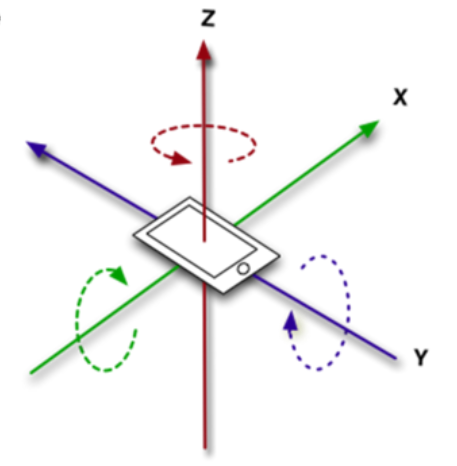

#### 3) 하위 5개 변수에 대한 분석

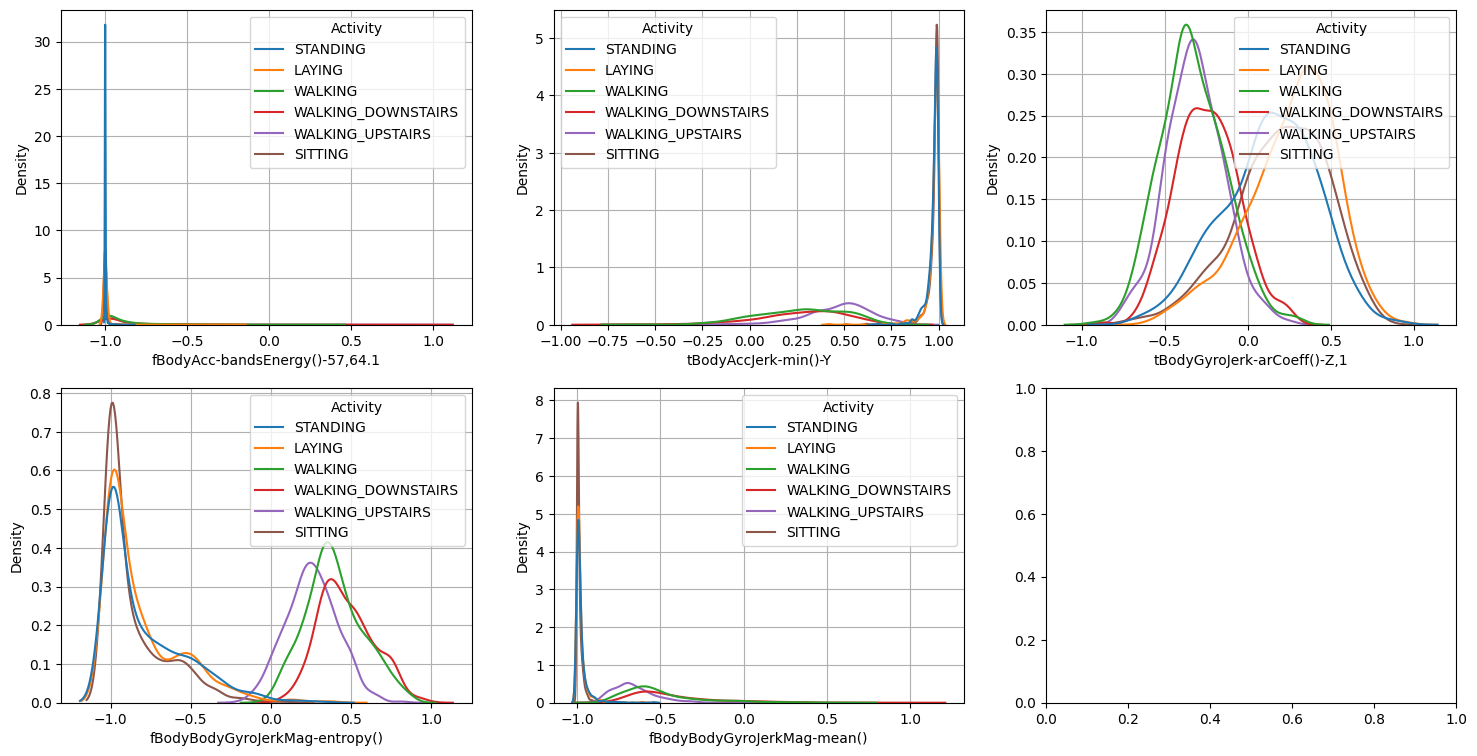

In [561]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
for i, ax in enumerate(axes.flatten()):
    if i < len(bottom): 
        sns.kdeplot(x=bottom[i], data = data, hue = target, ax=ax)
        ax.grid()
plt.show()

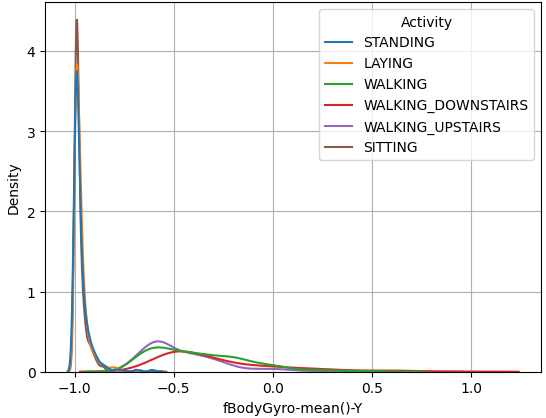

- **fBodyGyro-mean()-Y: Y축 방향 평균 각속도(회전 운동)**

- Standing, Laying, Sitting은 -1에서 밀도가 약 4.5로 매우 뾰족한 그래프
  - -1에 집중되어 있어 Y축 방향으로 평균 회전 운동이 매우 일관적.
  - 즉, 회전 운동이 거의 발생하지 않거나 일관된 동작을 반복

- Walking, Walking Upstairs, Walking Downstairs은 -0.3 ~ 0 사이에서 완만한 그래프(밀도 약 0.3)
  - 평균 각속도(회전 운동)가 크게 변동하며 특정 값에 집중되어 있지 않음.
  - 즉, 움직임이 다양, 복잡함.

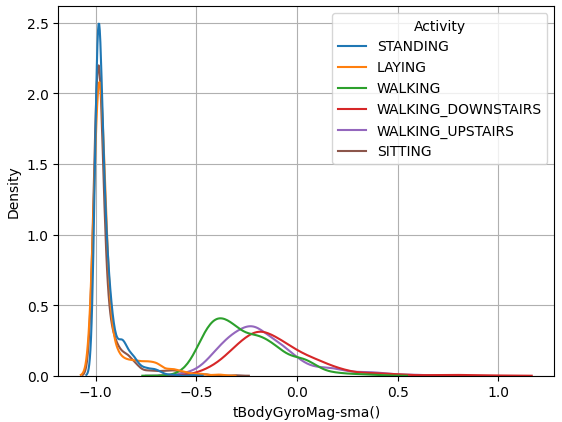

- **tBodyGyroMag-sma(): 자기 회전 속도(각속도)의 스칼라 모멘트 평균**

- Standing, Laying, Sitting은 -1에서 밀도가 약 2.5로 매우 뾰족한 그래프
  - -1에 집중되어 있어 안정된 상태 유지하는 경향 보임.
  - 예를 들어, 서거나 누워 있을 때 회전 속도가 거의 변하지 않기에 이 값에서 밀도가 높아지는 것.

- Walking, Walking Upstairs, Walking Downstairs은 -0.5 ~ 0 사이에서 완만한 그래프(밀도 약 0.4)
  - 평균 자기 회전 속도가 다양함.
  - 밀도가 약 0.3으로 낮은 것은 움직임이 매우 다양해서 특정 값에 집중되지 않기 때문.

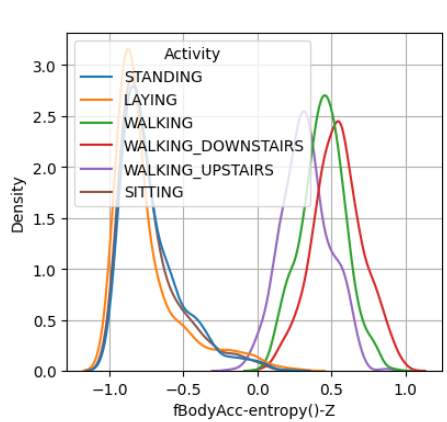

## 4.미션2 : 데이터 분석2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.



#### 1) is_dynamic 추가

In [576]:
data['is_dynamic'] = data['Activity'].map({
    'STANDING': 0,
    'SITTING': 0,
    'LAYING': 0,
    'WALKING': 1,
    'WALKING_UPSTAIRS': 1,
    'WALKING_DOWNSTAIRS': 1
})
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


#### 2) 기본모델 생성

In [578]:
from sklearn.model_selection import train_test_split

target = 'is_dynamic'

x = data.drop(columns=['Activity',target])
y = data.loc[:, target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [579]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[952   2]
 [  0 811]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00       811

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



#### 3) 변수중요도 상위 5개 분석

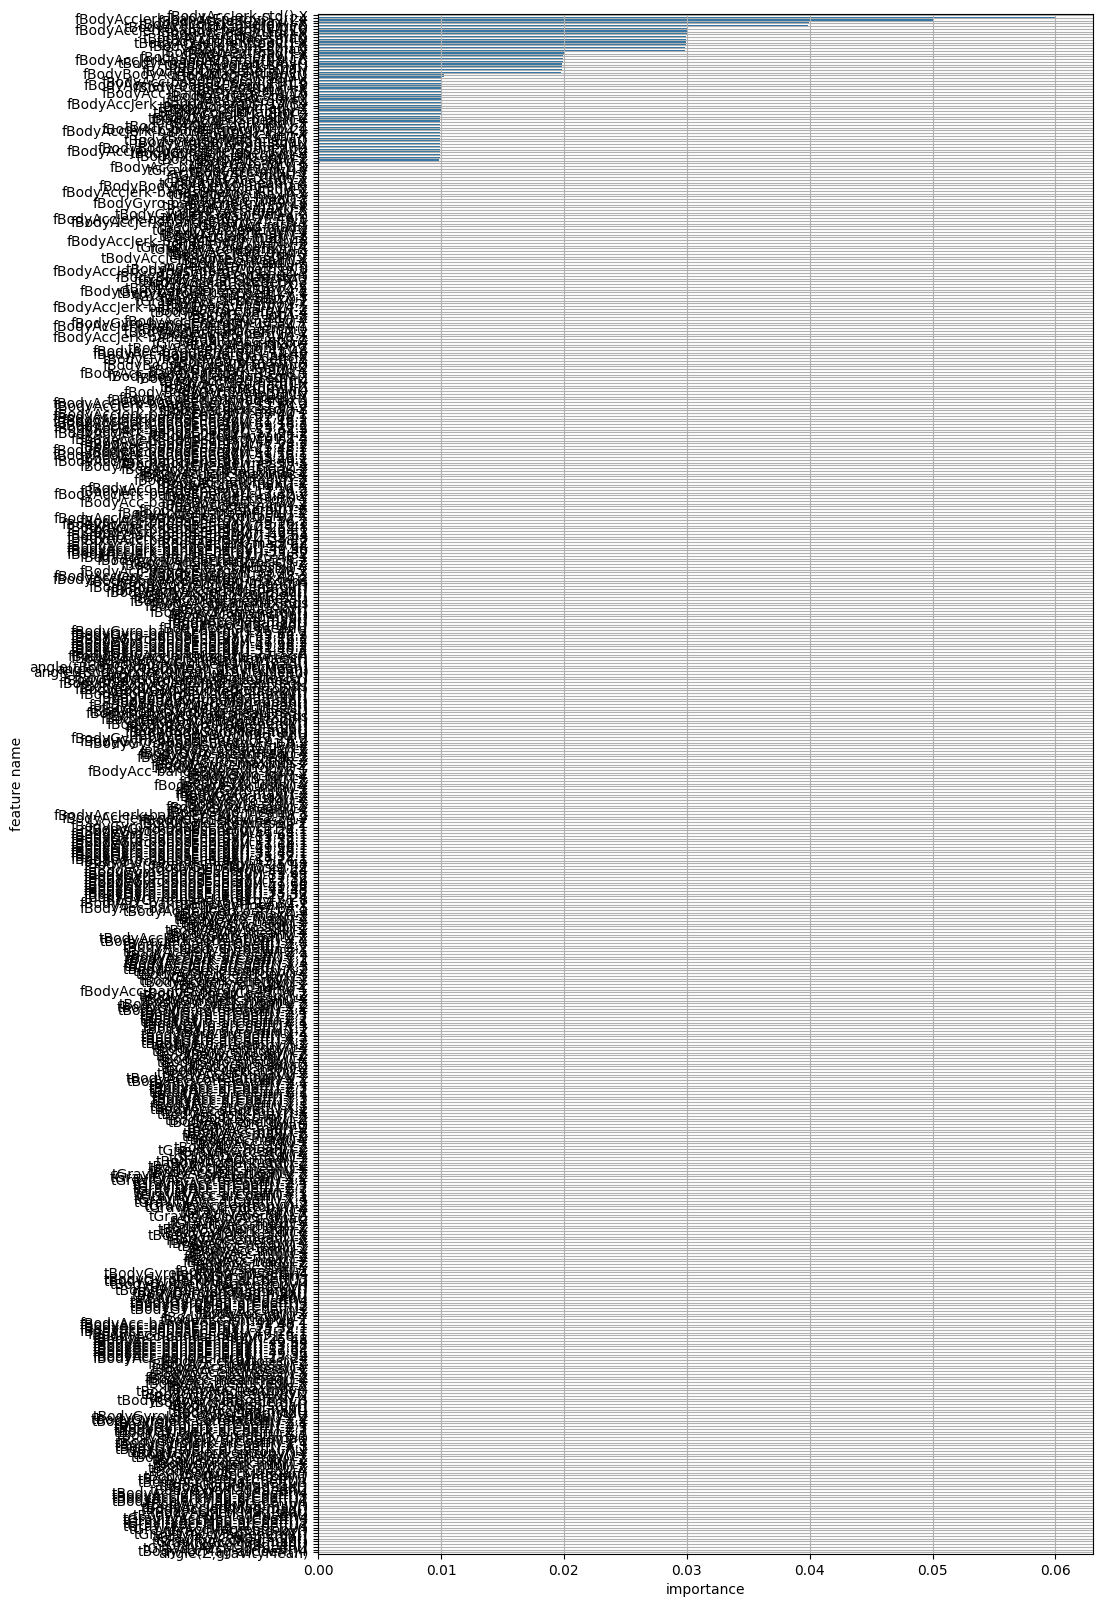

In [581]:
fi_df = plot_feature_importance(model.feature_importances_, x_train.columns, result_only = False, topn = 'all')

In [582]:
top = fi_df.head()
top

,feature_name,feature_importance
0,fBodyAccJerk-std()-X,0.060068
1,"fBodyAccJerk-bandsEnergy()-1,24",0.060059
2,fBodyAccJerk-max()-X,0.050049
3,tBodyAccJerk-energy()-X,0.039932
4,tBodyAccJerkMag-energy(),0.039863


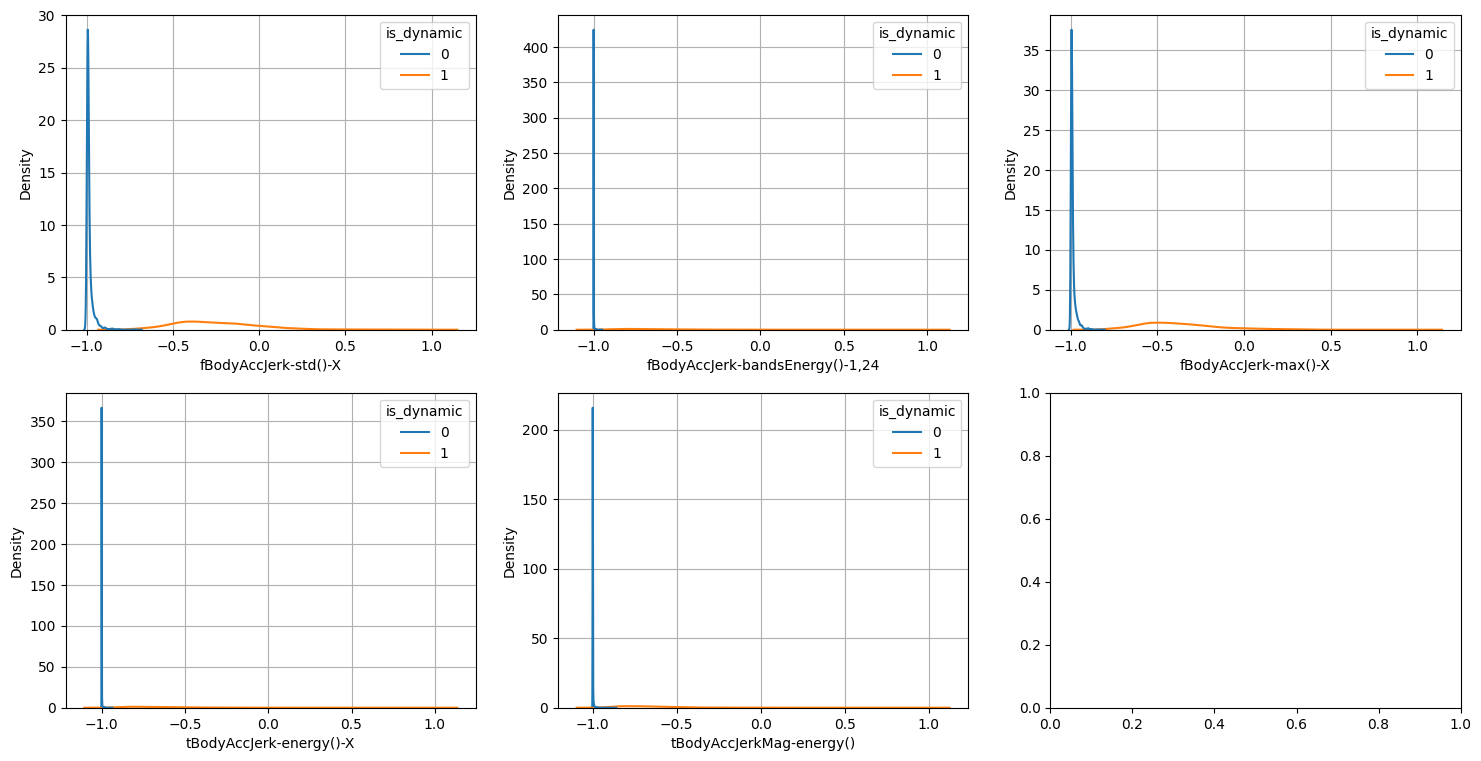

In [583]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
for i, ax in enumerate(axes.flatten()):
    if i < len(top): 
        feature = top['feature_name'].iloc[i] 
        sns.kdeplot(x=feature, data=data, hue=target, ax=ax)
        ax.grid()
plt.show()

- tBodyAccJerk-std()-X: 가속도 변화량의 X축 방향 표준편차
- 0 (정적)
- -1에서 엄청 뾰족한 형태의 그래프
- 몸이 거의 움직이지 않는 상태이며, 표준편차 값이 매우 작은 음수로 수렴하는 것으로 보아 가속도 변화량(변동)이 거의 없어 보임.
- 즉, 정적인 상태에서는 움직임이 거의 없고, 가속도 변화가 적으므로 X축 방향에서의 표준편차가 -1 부근에 집중되어 밀도가 매우 높게 나타남. -> 가속도 변화 매우 작고, 거의 일정함.
- 1 (동적)
- 대부분 -0.5 ~ 0 사이에 분포하지만 매우매우 완만한 형태의 그래프임.
- 밀도가 대략 1로, 가속도 변화가 훨씬 다양하고 빈도도 상대적으로 적어보임.
- 특정 값에 데이터가 집중되어 있지 않고 고르게 분포
- 즉, 움직임이 다양하게 일어나면서 X축 방향으로 분포가 넒고 특정 값에 집중되어 있지 않아 밀도가 낮음.

- tBodyAccJerkMag-entropy(): 가속도 변화의 크기와 관련된 엔트로피 (엔트로피: 데이터의 불확실성 또는 무질서도를 측정하는 지표)
- 0 (정적)
- -1 ~ -0.5 사이에 대부분 분포하며, 밀도가 2로 뾰족하고 오르쪽으로 꼬리가 긴 그래프
- 엔트로피 값(불확실성)이 낮고(음수) 한 곳에 몰려 있음.
- 즉, 움직임이 거의 없거나 매우 예측 가능한 상태이며, 오른쪽으로 꼬리가 긴 그래프 모양은 가끔씩 미세하게 움직이는 것으로 예측
- 1 (동적)
- 0.5 ~ 1 사이에 대부분 분포하며, 일도가 약 1.8로 뾰족한 형태의 그래프
- 엔트로피 값(불확실성)이 높고(양수) 한 곳에 몰려 있음.
- 즉, 움직임이 많고 변화가 크며, 특정 범위 내에서 반복적이고 일관된 움직임 패턴이 보임.(계단 오르기, 걷기 등)
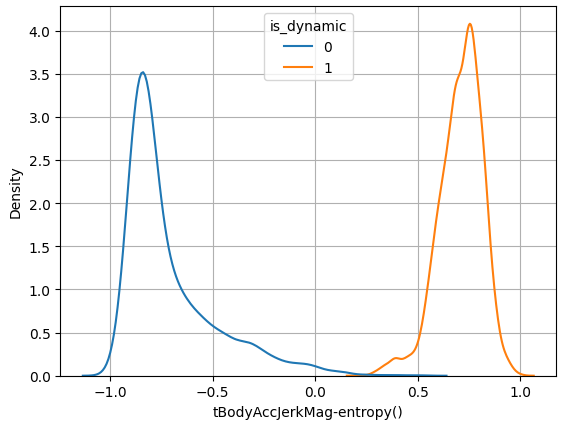

- fBodyAccJerk-mean()-X: 가속도의 변화량 X축 방향의 평균값
- 0 (정적)
- -1에서 매우 뾰족한 형태의 그래프 (밀도 25)
- -1 부근에 집중되어 있어 움직임이 거의 없거나 일관되며 X축 방향으로의 변화가 매우 적음.
- 밀도 25는 높은 값으로, 비슷한 수준의 가속도가 관찰
- 즉, 일관된 움직임과 예측 가능한 행동임을 보임.
- 1 (동적)
- 대부분 -0.5 ~ 0 사이에 분포하지만 매우매우 완만한 형태의 그래프 (밀도 약 1)
- 가속도의 평균값이 다양하고, 움직임이 복잡하고 불규칙
- 밀도 1로 매우 완만한 것은 가속도의 변화가 다양하고 여러 요인에 의해 영향을 받을 수 있음을 보임.
- 즉, 움직임이 다양하게 나타나며 예측하기 어려운 패턴이 존재.
- 
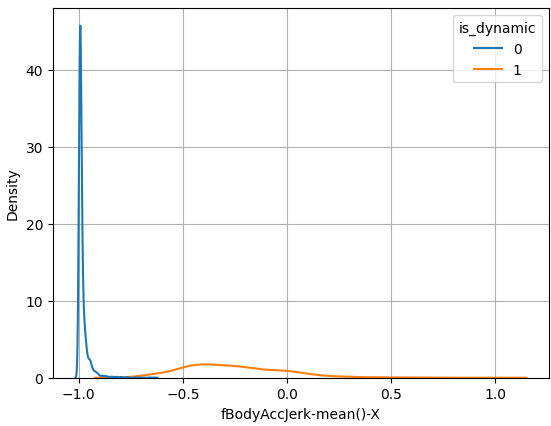

- tBodyAccJerk-iqr()-X: 가속도 변화량 X축 방향의 사분위 범위
- 0 (정적)
- -1에서 매우 뾰족하게 나타나며 밀도가 25
- IQR 값이 -1에 집중되어 있음.
- 밀도 25는 비슷한 수준의 IQR 값, 데이터가 매우 일관적
- 즉, 움직임이 거의 없어 일정한 IQR 값이 나타나고, 예측 가능한 행동(한곳에 값이 몰려 있음)
- 1 (동적)
- -0.5 ~ 0 사이에 대부분 분포하지만, 밀도가 약 1로 매우 완만한 그래프
- IQR 값이 다양하게 퍼져있음.
- 밀도 1로 가속도 변화가 다양, 범위 넒음.
- 즉, 움직임이 다양하고 예측하기 어려운 패턴 존재 (넓게 퍼져 있음)
- 
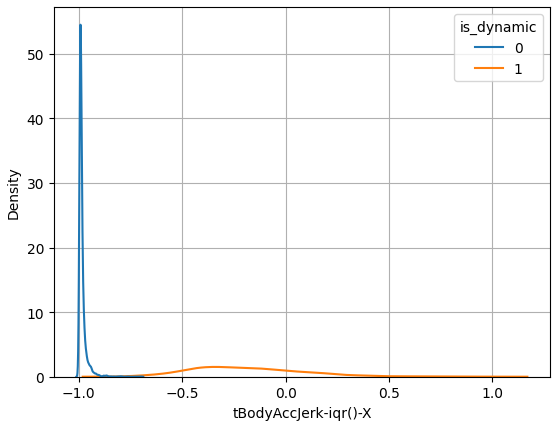

- fBodyAccJerk-bandsEnergy()-1,16: 주파수 도메인에서 가속도의 변화량에 대한 에너지 분포- 0 (정적)- -1에서 일직선이며, 밀도가 약 650- -1에 집중되어 있으며, 일관된 에너지 분포- 즉, 움직임 거의 없고 주파수 대역에서의 에너지가 일정하다 -1이면 정적- 1 (동적)- -1 ~ 1 사이에 밀도가 0인 일직선 그래프- 주파수 대역에서 에너지가 거의 없거나 분포가 없어 보임.- 균일하게 퍼져 있음.- 즉, 움직임이 복잡하고 예측할 수 없어 에너지가 특정 값에 할당되지 않음.- -1이 아니면 다 동적

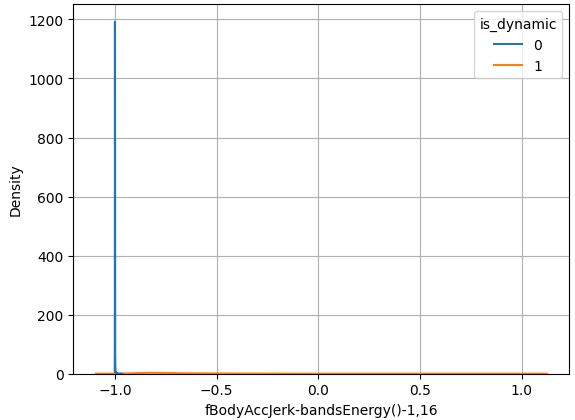